<a href="https://colab.research.google.com/github/goralex02/time-series-project/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с временными рядами стоимости акций

Контрольное задание
1.	Найти три любых временных ряда, связанных между собой.
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за год
2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию
3.	Выбрать в качестве основного один из рядов
4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить
5.	Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q
6.	Построить VAR модель
7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

Дополнительно:
8.	Построить модель на нейронных сетях

Примечание:  Работа должна содержать графики исходных сигналов и результатов моделирования


## 1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за год по одному часу

In [325]:
!pip install numpy==1.26.4

[*********************100%***********************]  3 of 3 completed


Datetime
0 days 01:00:00    1500
0 days 18:00:00     195
2 days 18:00:00      44
3 days 18:00:00       5
1 days 18:00:00       2
1 days 22:00:00       2
2 days 17:00:00       1
2 days 19:00:00       1
2 days 22:00:00       1
Name: count, dtype: int64


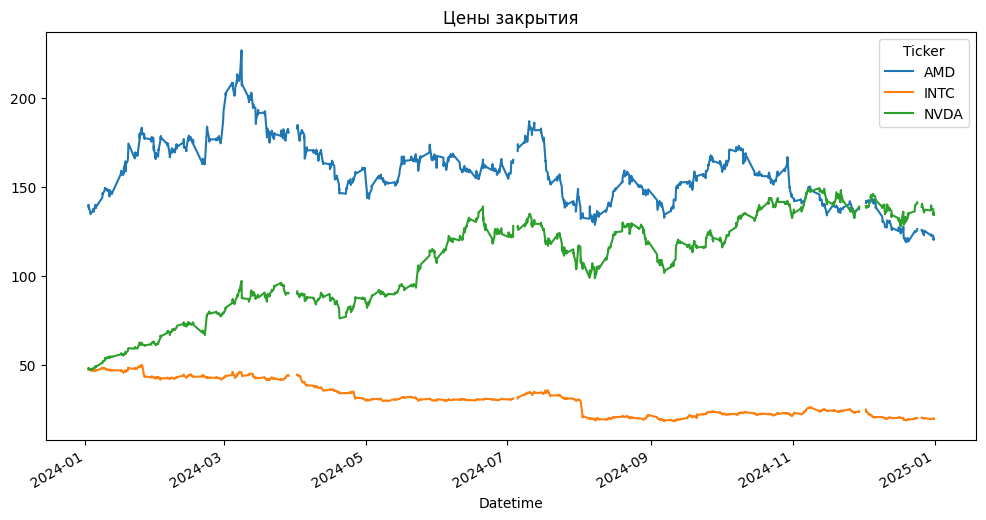

In [220]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
tickers = ['NVDA', 'AMD', 'INTC']
data = yf.download(tickers, start='2024-01-01', end='2025-01-01', interval='1h')['Close']

data.index = data.index.tz_convert('America/New_York')
print(data.index.to_series().diff().value_counts())
from pandas.tseries.offsets import CustomBusinessHour
from pandas.tseries.holiday import USFederalHolidayCalendar

# Торговые часы (9:30 - 16:30)
bh = CustomBusinessHour(start='9:30', end='16:30', calendar=USFederalHolidayCalendar())

data = data.asfreq(bh)  # Заполняем недостающие часы



# Визуализация
data.plot(figsize=(12, 6))
plt.title('Цены закрытия')
plt.show()

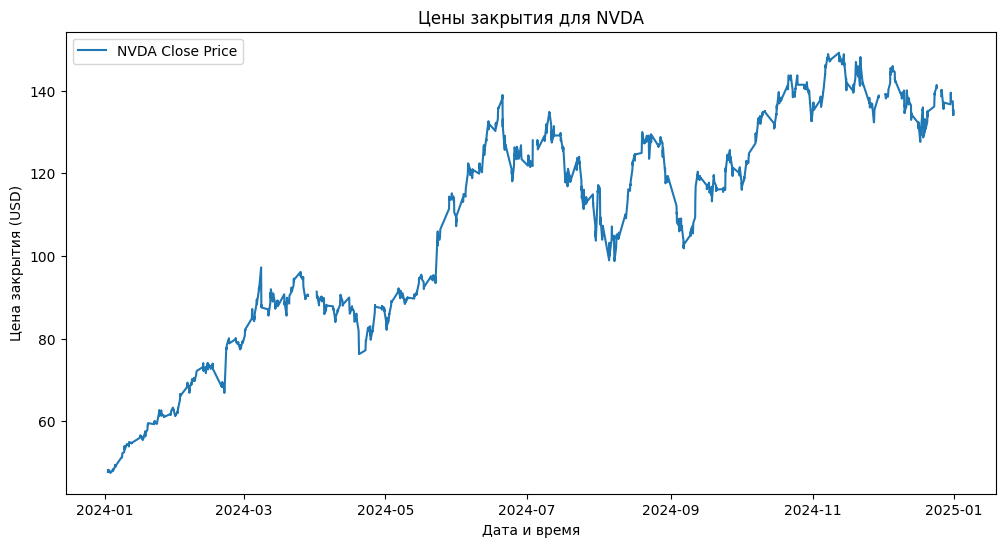

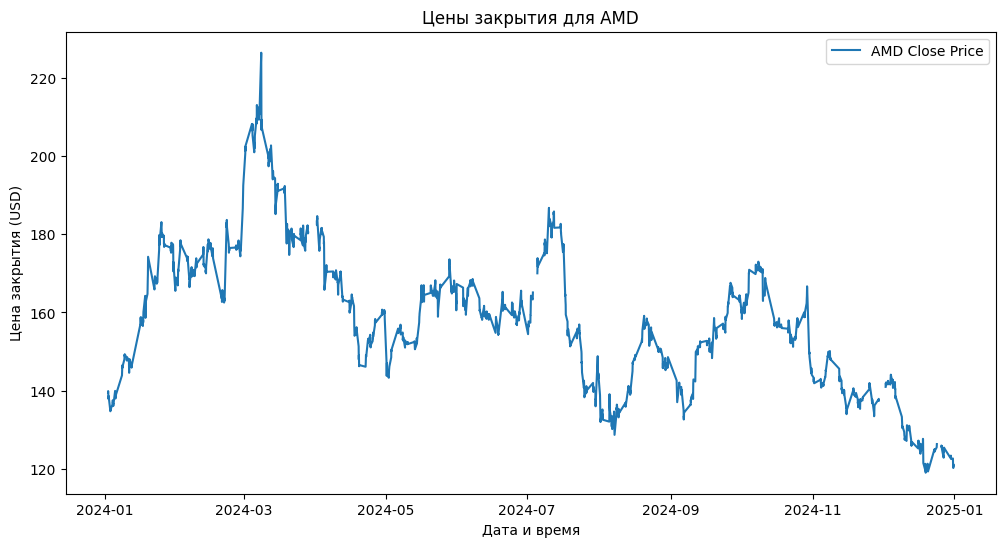

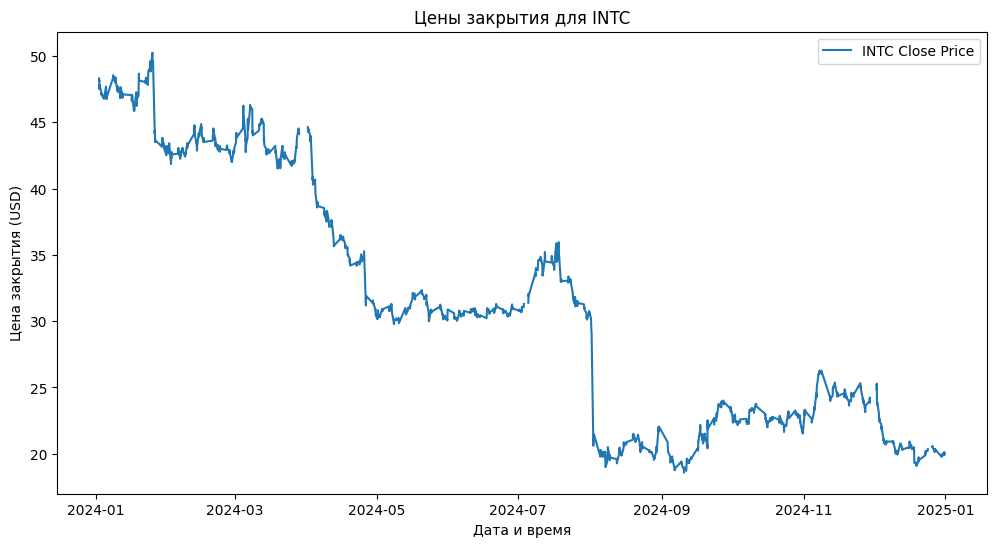

In [221]:
# Визуализация графиков для каждой акции
for ticker in tickers:
    plt.figure(figsize=(12, 6))
    plt.plot(data[ticker], label=f'{ticker} Close Price')
    plt.title(f'Цены закрытия для {ticker}')
    plt.xlabel('Дата и время')
    plt.ylabel('Цена закрытия (USD)')
    plt.legend()
    #plt.grid(True)
    plt.show()

In [222]:
# Проверим, есть ли даты, которые попадают на выходные
weekends = data.index[data.index.weekday >= 5]  # 5 = суббота, 6 = воскресенье
print(f"Количество записей в выходные: {len(weekends)}")
print(weekends)

Количество записей в выходные: 0
DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Datetime', freq='cbh')


Посмотрим на скачанные данные

In [223]:
print(data.head())

Ticker                            AMD       INTC       NVDA
Datetime                                                   
2024-01-02 09:30:00-05:00  139.389999  48.307701  47.667000
2024-01-02 10:30:00-05:00  139.856598  48.189899  48.116020
2024-01-02 11:30:00-05:00  139.259995  48.115002  48.108528
2024-01-02 12:30:00-05:00  139.175003  48.165001  48.185997
2024-01-02 13:30:00-05:00  138.459900  47.834999  48.188000


In [224]:
print(data.tail())

Ticker                            AMD       INTC        NVDA
Datetime                                                    
2024-12-31 11:30:00-05:00  120.587700  19.885000  135.050003
2024-12-31 12:30:00-05:00  120.309998  19.990000  134.429993
2024-12-31 13:30:00-05:00  120.180000  19.930000  134.119995
2024-12-31 14:30:00-05:00  121.139999  20.084999  135.461502
2024-12-31 15:30:00-05:00  120.790001  20.059999  134.289993


## 2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию

In [225]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1757 entries, 2024-01-02 09:30:00-05:00 to 2024-12-31 15:30:00-05:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     1738 non-null   float64
 1   INTC    1738 non-null   float64
 2   NVDA    1738 non-null   float64
dtypes: float64(3)
memory usage: 54.9 KB
None


Заполним NaN предыдущим известным значением

In [226]:
data = data.fillna(method='ffill')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1757 entries, 2024-01-02 09:30:00-05:00 to 2024-12-31 15:30:00-05:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     1757 non-null   float64
 1   INTC    1757 non-null   float64
 2   NVDA    1757 non-null   float64
dtypes: float64(3)
memory usage: 54.9 KB
None


<ipython-input-226-79fc2e98e85c>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Посмотрим на STL разложение для AMD

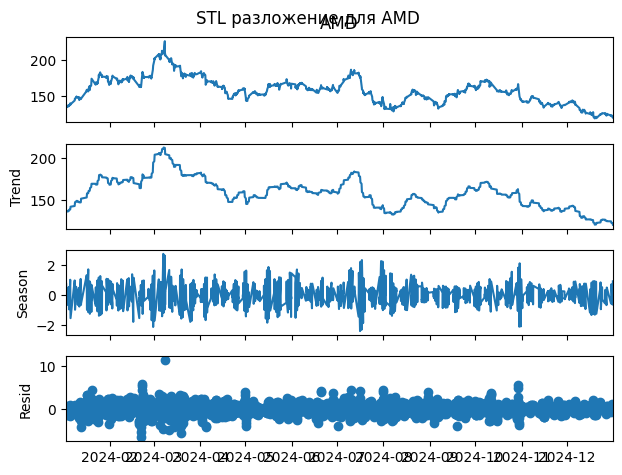

In [227]:
from statsmodels.tsa.seasonal import STL
# Анализ для AMD
ticker = 'AMD'
series = data[ticker]

# Разложение временного ряда с помощью STL, у нас 7 торговых часов в дне
stl = STL(series, seasonal=7, period=7)
result = stl.fit()

# Визуализация компонент
result.plot()
plt.suptitle(f'STL разложение для {ticker}')
plt.show()

Посмотрим на нормализованные ряды

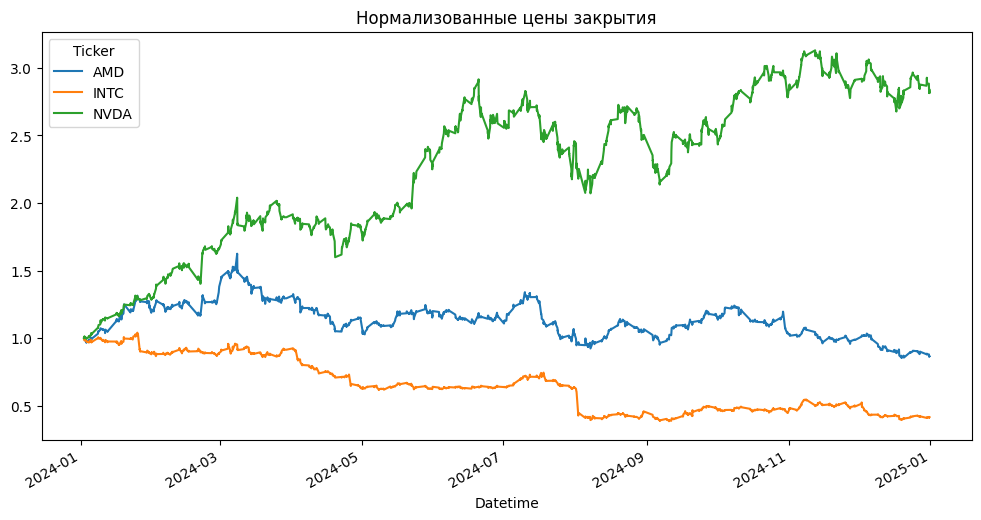

In [228]:
# Нормализация (приведение к одному масштабу, начало с 1)
normalized_data = data / data.iloc[0]
normalized_data.plot(figsize=(12, 6))
plt.title('Нормализованные цены закрытия')
plt.show()

Посмотрим наличие пропусков, дубликатов

In [229]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1757 entries, 2024-01-02 09:30:00-05:00 to 2024-12-31 15:30:00-05:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     1757 non-null   float64
 1   INTC    1757 non-null   float64
 2   NVDA    1757 non-null   float64
dtypes: float64(3)
memory usage: 54.9 KB
None


In [230]:
print(data.AMD.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 1757 entries, 2024-01-02 09:30:00-05:00 to 2024-12-31 15:30:00-05:00
Freq: cbh
Series name: AMD
Non-Null Count  Dtype  
--------------  -----  
1757 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB
None


In [231]:
print(data.isnull().sum())

Ticker
AMD     0
INTC    0
NVDA    0
dtype: int64


Дубли появятся из-за заполнения пропусков

In [232]:
print(data.duplicated().sum())

19


Посмотрим на основные статистические характеристики

In [233]:
print(data.describe())

Ticker          AMD         INTC         NVDA
count   1757.000000  1757.000000  1757.000000
mean     157.807356    31.163161   107.512981
std       18.123091     9.336741    26.804404
min      118.970001    18.566200    47.494488
25%      144.160004    22.475000    87.800003
50%      157.358795    30.646200   114.690002
75%      169.070007    41.880001   129.990005
max      226.450104    50.244999   149.220001


Проверим наличие выбросов с помощью ящика с усами

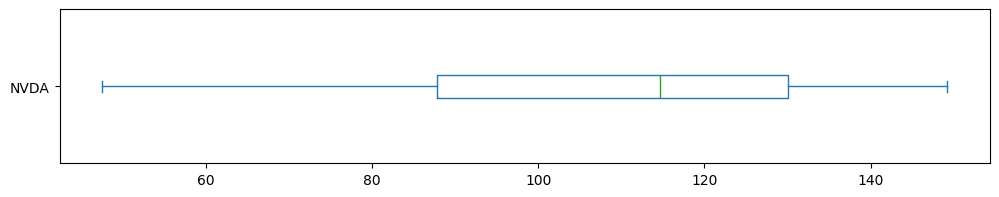

In [234]:
data.NVDA.plot.box(figsize=(12, 2), vert=False);

Видны выбросы у AMD, но почти все они в одном диапазоне примерно от 205 до 215

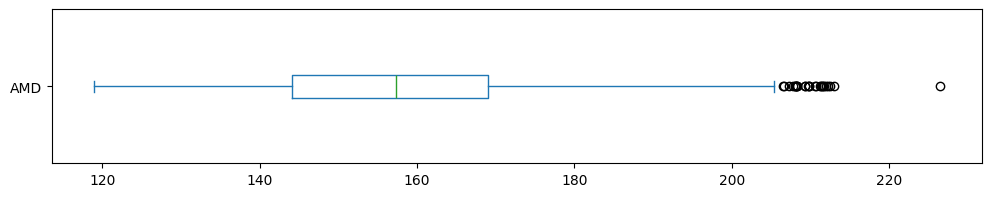

In [235]:
data.AMD.plot.box(figsize=(12, 2), vert=False);

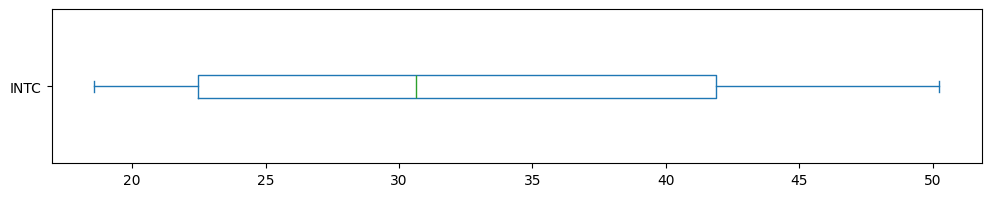

In [236]:
data.INTC.plot.box(figsize=(12, 2), vert=False);

Проверим корреляцию

In [237]:
# Корреляционная матрица
corr_matrix = data.corr()
print("Корреляция между рядами:")
print(corr_matrix)


Корреляция между рядами:
Ticker       AMD      INTC      NVDA
Ticker                              
AMD     1.000000  0.660554 -0.402905
INTC    0.660554  1.000000 -0.820463
NVDA   -0.402905 -0.820463  1.000000


Проведем тест Дики-Фуллера на стационарность рядов

In [238]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name):
    result = adfuller(series)
    print(f"Тест Дики-Фуллера для {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

for col in data.columns:
    test_stationarity(data[col], col)

Тест Дики-Фуллера для AMD:
ADF Statistic: -1.7690241818450765
p-value: 0.3959451090676023
Ряд нестационарен.
Тест Дики-Фуллера для INTC:
ADF Statistic: -1.4370982691138012
p-value: 0.5643672644945548
Ряд нестационарен.
Тест Дики-Фуллера для NVDA:
ADF Statistic: -1.9916435751112298
p-value: 0.29024907745900363
Ряд нестационарен.


Проведем этот же тест для дифференцированных рядов

In [239]:
data_diff = data.diff().dropna()

for col in data_diff.columns:
    test_stationarity(data_diff[col], f"{col} (дифференцированный)")

Тест Дики-Фуллера для AMD (дифференцированный):
ADF Statistic: -42.47157478266555
p-value: 0.0
Ряд стационарен.
Тест Дики-Фуллера для INTC (дифференцированный):
ADF Statistic: -43.254897031202866
p-value: 0.0
Ряд стационарен.
Тест Дики-Фуллера для NVDA (дифференцированный):
ADF Statistic: -19.91933965731804
p-value: 0.0
Ряд стационарен.


Посмотрим на дифференцированные цены закрытия

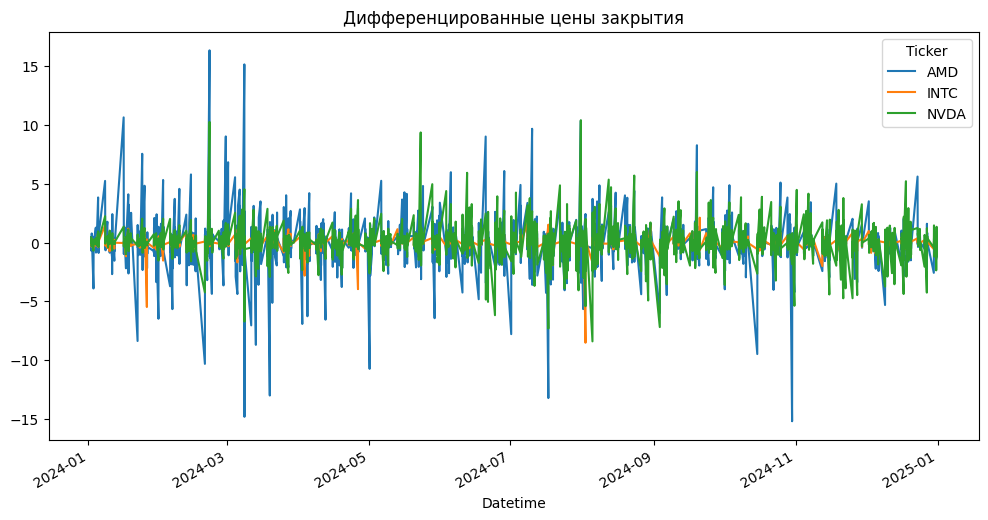

In [240]:
data_diff.plot(figsize=(12, 6))
plt.title('Дифференцированные цены закрытия')
plt.show()

In [241]:
print(data_diff.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1756 entries, 2024-01-02 10:30:00-05:00 to 2024-12-31 15:30:00-05:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     1756 non-null   float64
 1   INTC    1756 non-null   float64
 2   NVDA    1756 non-null   float64
dtypes: float64(3)
memory usage: 54.9 KB
None


In [242]:
print(data_diff.head())

Ticker                          AMD      INTC      NVDA
Datetime                                               
2024-01-02 10:30:00-05:00  0.466599 -0.117802  0.449020
2024-01-02 11:30:00-05:00 -0.596603 -0.074898 -0.007492
2024-01-02 12:30:00-05:00 -0.084991  0.049999  0.077469
2024-01-02 13:30:00-05:00 -0.715103 -0.330002  0.002003
2024-01-02 14:30:00-05:00 -0.634903 -0.340000 -0.304001


In [243]:
print(data_diff.tail())

Ticker                          AMD      INTC      NVDA
Datetime                                               
2024-12-31 11:30:00-05:00 -0.602402 -0.119999 -0.059998
2024-12-31 12:30:00-05:00 -0.277702  0.105000 -0.620010
2024-12-31 13:30:00-05:00 -0.129997 -0.059999 -0.309998
2024-12-31 14:30:00-05:00  0.959999  0.154999  1.341507
2024-12-31 15:30:00-05:00 -0.349998 -0.025000 -1.171509


Проведем тест Йохансена для проверки коинтеграции

In [244]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Тест Йохансена (лаг = 1)
result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Вывод результатов
print("Критические значения (90%, 95%, 99%):\n", result.cvt)
print("Статистики теста:\n", result.lr1)

# Проверка гипотезы о наличии коинтеграции (на уровне 95%)
critical_value_95 = result.cvt[1, 1]  # Вторая строка — 95% уровень
if result.lr1[0] > critical_value_95:
    print("Есть коинтеграция (p < 0.05)")
else:
    print("Нет коинтеграции")

Критические значения (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Статистики теста:
 [27.75136173 10.7446004   1.11264053]
Есть коинтеграция (p < 0.05)


Проверим коинтеграцию с пакетом statsmodels

In [245]:
from statsmodels.tsa.stattools import coint

def test_cointegration(series1, series2, name1, name2):
    score, p_value, _ = coint(series1, series2)
    print(f"Тест коинтеграции между {name1} и {name2}:")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("Ряды коинтегрированы.")
    else:
        print("Ряды не коинтегрированы.")

# Проверка коинтеграции для всех пар
pairs = [('NVDA', 'AMD'), ('NVDA', 'INTC'), ('AMD', 'INTC')]
for pair in pairs:
    test_cointegration(data[pair[0]], data[pair[1]], pair[0], pair[1])

Тест коинтеграции между NVDA и AMD:
p-value: 0.13091865993533852
Ряды не коинтегрированы.
Тест коинтеграции между NVDA и INTC:
p-value: 0.28116441021106986
Ряды не коинтегрированы.
Тест коинтеграции между AMD и INTC:
p-value: 0.05545846733856905
Ряды не коинтегрированы.


## 3.	Выбрать в качестве основного один из рядов

Можно взять AMD (он хорошо коррелирует с INTC и становится стационарным после дифференцирования).


## 4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить

Проверим автокорреляцию дифференцирования AMD

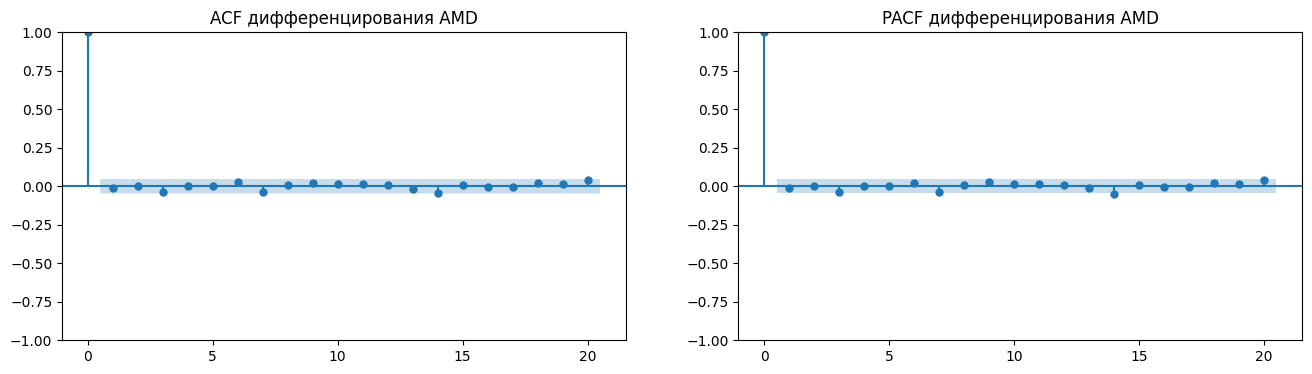

In [246]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

amd_diff = data_diff['AMD']

# Фигура для ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
sm.graphics.tsa.plot_acf(amd_diff, lags=20, ax=axes[0])
axes[0].set_title('ACF дифференцирования AMD')

# PACF
sm.graphics.tsa.plot_pacf(amd_diff, lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF дифференцирования AMD')

plt.show()

In [247]:
from statsmodels.tsa.arima.model import ARIMA

# Строим ARIMA модель
model_arima = ARIMA(data['AMD'], order=(1, 1, 1))
result_arima = model_arima.fit()

# Сводка модели
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                    AMD   No. Observations:                 1757
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3566.953
Date:                Wed, 19 Mar 2025   AIC                           7139.907
Time:                        16:55:24   BIC                           7156.319
Sample:                    01-02-2024   HQIC                          7145.973
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9529      0.058    -16.494      0.000      -1.066      -0.840
ma.L1          0.9414      0.064     14.663      0.000       0.816       1.067
sigma2         3.4031      0.037     91.727      0.0

In [248]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Берем регрессоры
exog = data[['INTC', 'NVDA']]

# Строим ARIMAX модель
model_arimax = SARIMAX(data['AMD'], exog=exog, order=(1, 1, 1))
result_arimax = model_arimax.fit()

# Сводка модели
print(result_arimax.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    AMD   No. Observations:                 1757
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3208.347
Date:                Wed, 19 Mar 2025   AIC                           6426.693
Time:                        16:55:25   BIC                           6454.047
Sample:                    01-02-2024   HQIC                          6436.803
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INTC           0.6403      0.024     27.068      0.000       0.594       0.687
NVDA           0.7632      0.012     62.974      0.000       0.739       0.787
ar.L1         -0.0030      5.462     -0.001      1.0

1. ARIMA(1, 1, 1):

* ar.L1 : -0.9529 (p-value < 0.0001)

Коэффициент авторегрессии первого порядка значимо отличен от нуля. Это указывает на сильную зависимость текущего значения от предыдущего.

* ma.L1 : 0.9414 (p-value < 0.0001)

Коэффициент скользящего среднего первого порядка также значимо отличен от нуля. Модель учитывает ошибки предыдущих прогнозов.

* sigma2 : 3.4031

Дисперсия остатков. Чем меньше это значение, тем лучше модель подходит к данным.

2. SARIMAX(1, 1, 1):

* INTC : 0.6403 (p-value < 0.0001)

Влияние Intel на AMD значимо положительно. Увеличение курса Intel на 1% приводит к увеличению курса AMD примерно на 0.64%.

* NVDA : 0.7632 (p-value < 0.0001)

Влияние NVIDIA на AMD также значимо положительно. Увеличение курса NVIDIA на 1% приводит к увеличению курса AMD примерно на 0.76%.

* ar.L1 : -0.0030 (p-value = 1.000)

Коэффициент авторегрессии не значим (p-value ≈ 1). Это может говорить о том, что добавление внешних регрессоров уменьшило автокорреляцию в данных.

* ma.L1 : -0.0027 (p-value = 1.000)

Аналогично, коэффициент скользящего среднего не значим.

* sigma2 : 2.2620

Дисперсия остатков значительно ниже, чем в ARIMA (2.2620 против 3.4031). Это подтверждает, что SARIMAX лучше описывает данные.

* Информационные критерии
AIC, BIC и HQIC для SARIMAX значительно ниже, чем для ARIMA. Это говорит о том, что SARIMAX лучше описывает данные.
* Коэффициенты:
В SARIMAX внешние регрессоры (INTC и NVDA) оказывают значимое влияние на AMD. Это делает модель более интерпретируемой и полезной для прогнозирования.
* Остатки:
Обе модели имеют проблемы с нормальностью и гетероскедастичностью остатков. Однако SARIMAX показывает меньшую дисперсию остатков (2.2620 против 3.4031), что делает её предпочтительнее.

Проверим остатки модели

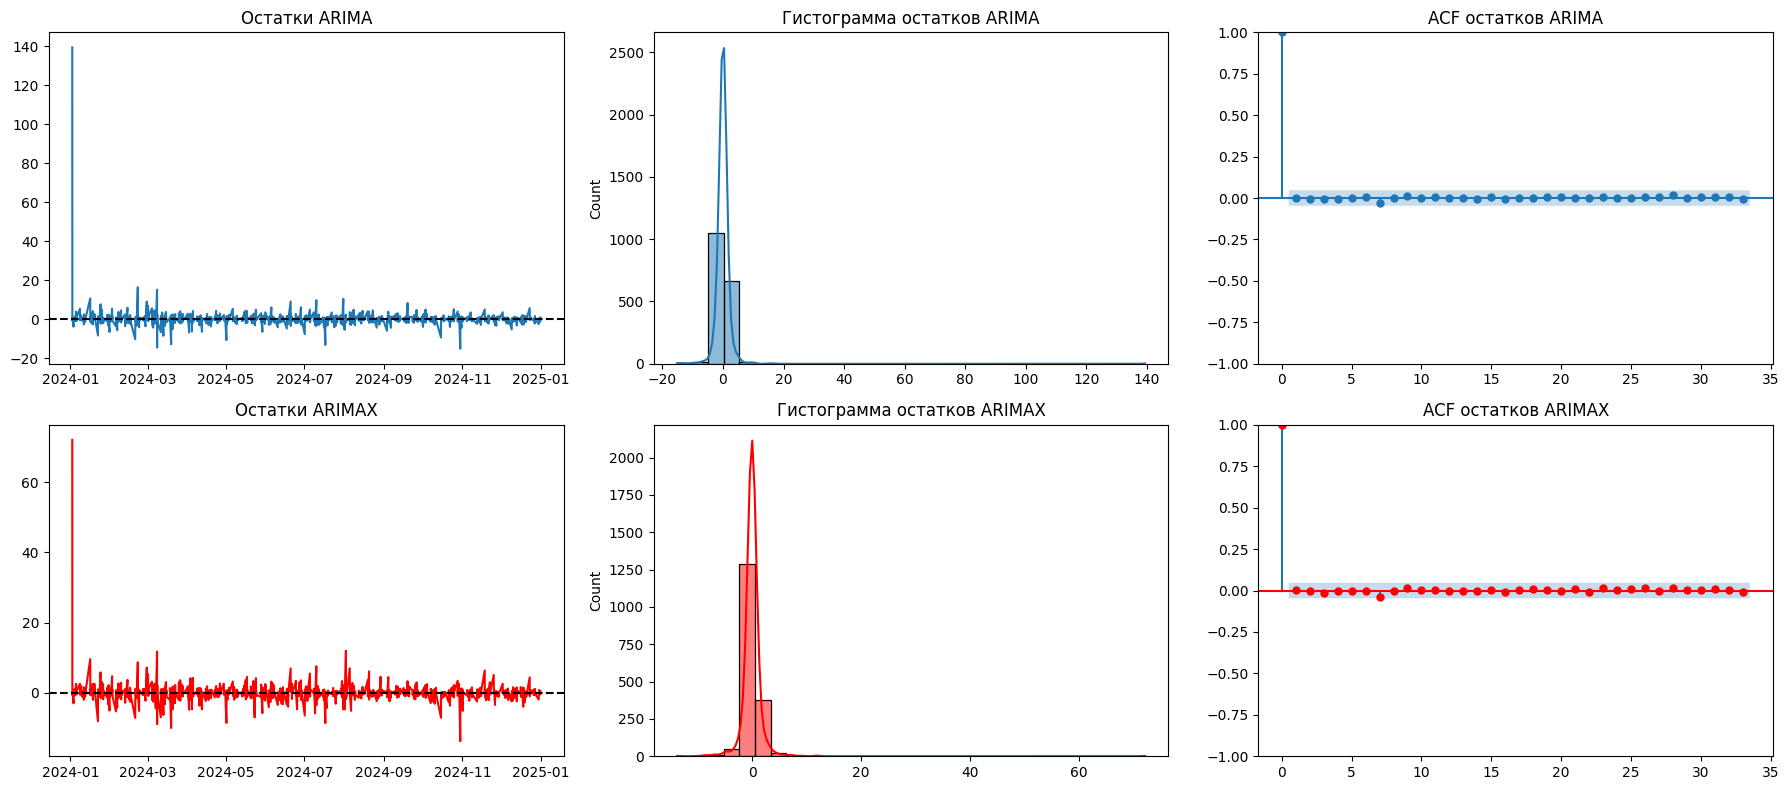

In [249]:
import seaborn as sns
import statsmodels.api as sm
# Получаем остатки модели
residuals_arima = result_arima.resid
residuals_arimax = result_arimax.resid

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# 1. Временной ряд остатков ARIMA
axes[0, 0].plot(residuals_arima, label="Остатки ARIMA")
axes[0, 0].axhline(0, linestyle="--", color="black")
axes[0, 0].set_title("Остатки ARIMA")

# 2. Гистограмма остатков ARIMA
sns.histplot(residuals_arima, bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Гистограмма остатков ARIMA")

# 3. ACF остатков ARIMA
sm.graphics.tsa.plot_acf(residuals_arima, ax=axes[0, 2])
axes[0, 2].set_title("ACF остатков ARIMA")

# 4. Временной ряд остатков ARIMAX
axes[1, 0].plot(residuals_arimax, label="Остатки ARIMAX", color="red")
axes[1, 0].axhline(0, linestyle="--", color="black")
axes[1, 0].set_title("Остатки ARIMAX")

# 5. Гистограмма остатков ARIMAX
sns.histplot(residuals_arimax, bins=30, kde=True, ax=axes[1, 1], color="red")
axes[1, 1].set_title("Гистограмма остатков ARIMAX")

# 6. ACF остатков ARIMAX
sm.graphics.tsa.plot_acf(residuals_arimax, ax=axes[1, 2], color='red')
axes[1, 2].set_title("ACF остатков ARIMAX")

plt.tight_layout()
plt.show()

Проверим автокорреляцию остатков

In [250]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Для ARIMA
lb_test_arima = acorr_ljungbox(residuals_arima, lags=10)
print("ARIMA p-values:", lb_test_arima.iloc[:, 1].values)

# Для ARMAX
lb_test_armax = acorr_ljungbox(residuals_arimax, lags=10)
print("ARMAX p-values:", lb_test_armax.iloc[:, 1].values)

ARIMA p-values: [0.92340632 0.97196059 0.98656236 0.9955412  0.99915061 0.99943522
 0.97397299 0.98849007 0.99262804 0.99689332]
ARMAX p-values: [0.94701387 0.99127533 0.942392   0.983008   0.99548935 0.99882136
 0.90141471 0.9447082  0.9537111  0.97435005]


 Все p-values > 0.05 → остатки не имеют автокорреляции.

Попробуем спрогнозировать значения ряда с помощью моделей

In [251]:
# Разделение на train/test
train_size = round(0.9 * len(data['AMD']))
train, test = data['AMD'][:train_size], data['AMD'][train_size:]
print(len(train))
print(len(test))

1581
176


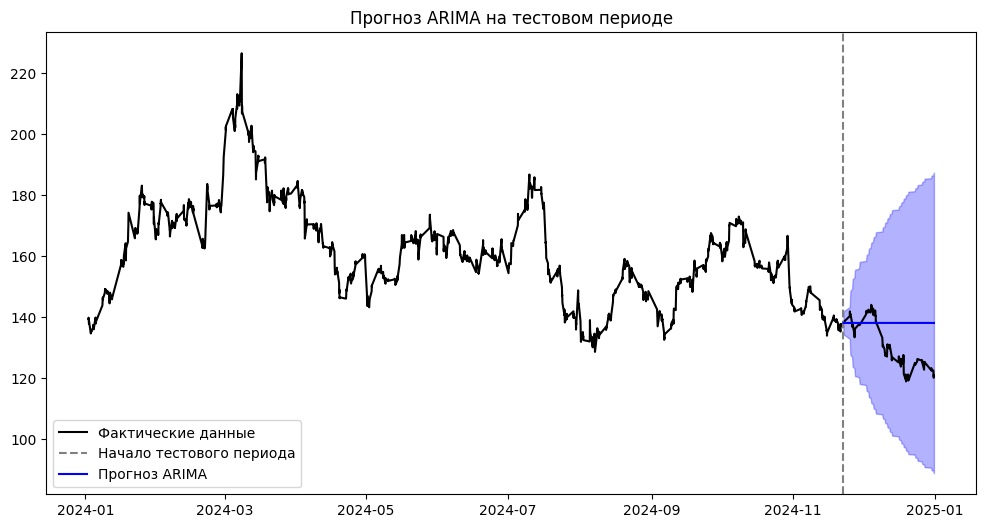

In [252]:
# Обучаем ARIMA только на train (без регрессоров)
model_arima_train = ARIMA(train, order=(1, 1, 1))
result_arima_train = model_arima_train.fit()

# Делаем прогноз на тестовые данные
forecast_arima = result_arima_train.get_forecast(steps=len(test))
forecast_arima_mean = forecast_arima.predicted_mean
forecast_arima_ci = forecast_arima.conf_int()

# Визуализация прогноза ARIMA
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AMD'], label="Фактические данные", color="black")
plt.axvline(data.index[train_size], linestyle="--", color="gray", label="Начало тестового периода")
plt.plot(test.index, forecast_arima_mean, label="Прогноз ARIMA", color="blue")
plt.fill_between(test.index, forecast_arima_ci.iloc[:, 0], forecast_arima_ci.iloc[:, 1], color="blue", alpha=0.3)
plt.legend()
plt.title("Прогноз ARIMA на тестовом периоде")
plt.show()


Константный прогноз — это следствие:

Незначимых AR/MA параметров.

Стационарности данных.

In [253]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae_arima = mean_absolute_error(test, forecast_arima_mean)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima_mean))

print(f"MAE ARIMA: {mae_arima:.4f}")
print(f"RMSE ARIMA: {rmse_arima:.4f}")

MAE ARIMA: 9.0441
RMSE ARIMA: 10.6274


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


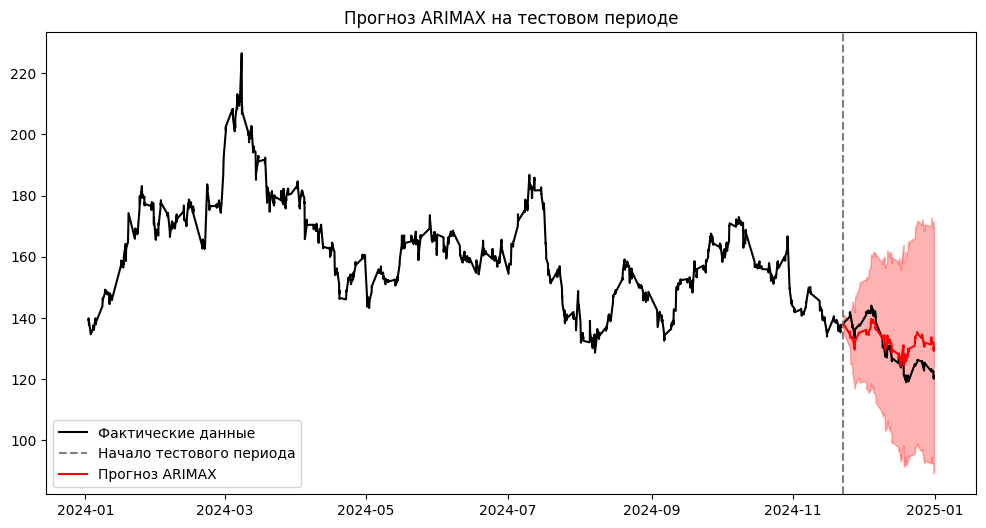

In [254]:
# Обучаем ARIMAX только на train
exog_train, exog_test = data[['INTC', 'NVDA']][:train_size], data[['INTC', 'NVDA']][train_size:]
model_arimax_train = SARIMAX(train, exog=exog_train, order=(1, 1, 1))
result_arimax_train = model_arimax_train.fit()

# Делаем прогноз на тест
forecast = result_arimax_train.get_forecast(steps=len(test), exog=exog_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AMD'], label="Фактические данные", color="black")
plt.axvline(data.index[train_size], linestyle="--", color="gray", label="Начало тестового периода")
plt.plot(test.index, forecast_mean, label="Прогноз ARIMAX", color="red")
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="red", alpha=0.3)
plt.legend()
plt.title("Прогноз ARIMAX на тестовом периоде")
plt.show()

In [255]:
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 5.0414
RMSE: 5.7716


Благодаря экзогенным переменным ARIMAX корректнее предсказывает значения ряда

## 5. Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q

In [256]:
!pip install arch -q

Будем использовать логарифмическую доходность ввиду простоты использования

In [257]:
from arch import arch_model

# 1. Вычисляем логарифмическую доходность
data['AMD_log_return'] = np.log(data['AMD'] / data['AMD'].shift(1))

# 2. Удаляем NaN после сдвига
returns = data['AMD_log_return'].dropna()

# 3. Проверяем стационарность
adf_test = adfuller(returns)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")  # p-value < 0.05 → ряд стационарен

# 4. Разделяем данные на train/test
train_size = round(0.9 * len(data['AMD']))
train, test = returns[:train_size], returns[train_size:]

ADF Statistic: -41.88809976682067
p-value: 0.0


Попробуем несколько разных вариантов моделей

In [258]:
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5389.56
Distribution:                  Normal   AIC:                          -10771.1
Method:            Maximum Likelihood   BIC:                          -10749.2
                                        No. Observations:                 1756
Date:                Wed, Mar 19 2025   Df Residuals:                     1755
Time:                        16:55:33   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.4219e-05  2.653e-04     -0.242      0.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [259]:
garch_model12 = arch_model(returns, vol='Garch', p=1, q=2)
garch_result12 = garch_model12.fit(disp='off')
print(garch_result12.summary())

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5386.43
Distribution:                  Normal   AIC:                          -10762.9
Method:            Maximum Likelihood   BIC:                          -10735.5
                                        No. Observations:                 1756
Date:                Wed, Mar 19 2025   Df Residuals:                     1755
Time:                        16:55:33   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.2146e-05  2.674e-04     -0.270      0.

In [260]:
garch_model21 = arch_model(returns, vol='Garch', p=2, q=1)
garch_result21 = garch_model21.fit(disp='off')
print(garch_result21.summary())

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5389.56
Distribution:                  Normal   AIC:                          -10769.1
Method:            Maximum Likelihood   BIC:                          -10741.8
                                        No. Observations:                 1756
Date:                Wed, Mar 19 2025   Df Residuals:                     1755
Time:                        16:55:33   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.4555e-05  2.671e-04     -0.242      0.

In [261]:
egarch_model = arch_model(returns, vol='EGarch', p=1, q=1)
egarch_result = egarch_model.fit(disp='off')
print(egarch_result.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                5389.39
Distribution:                  Normal   AIC:                          -10770.8
Method:            Maximum Likelihood   BIC:                          -10748.9
                                        No. Observations:                 1756
Date:                Wed, Mar 19 2025   Df Residuals:                     1755
Time:                        16:55:33   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.2370e-05  2.797e-04     -0.223      0.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [262]:
egarch_model12 = arch_model(returns, vol='EGarch', p=1, q=2)
egarch_result12 = egarch_model12.fit(disp='off')
print(egarch_result12.summary())

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                5389.39
Distribution:                  Normal   AIC:                          -10768.8
Method:            Maximum Likelihood   BIC:                          -10741.4
                                        No. Observations:                 1756
Date:                Wed, Mar 19 2025   Df Residuals:                     1755
Time:                        16:55:33   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.2435e-05  2.791e-04     -0.224      0.

In [263]:
egarch_model21 = arch_model(returns, vol='EGarch', p=2, q=1)
egarch_result21 = egarch_model21.fit(disp='off')
print(egarch_result21.summary())

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                5413.32
Distribution:                  Normal   AIC:                          -10816.6
Method:            Maximum Likelihood   BIC:                          -10789.3
                                        No. Observations:                 1756
Date:                Wed, Mar 19 2025   Df Residuals:                     1755
Time:                        16:55:34   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.0907e-04  1.834e-04     -0.595      0.

In [264]:
gjr_model = arch_model(returns, vol='Garch', p=1, q=1, o=1)
gjr_result = gjr_model.fit(disp='off')
print(gjr_result.summary())

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                5383.66
Distribution:                  Normal   AIC:                          -10757.3
Method:            Maximum Likelihood   BIC:                          -10730.0
                                        No. Observations:                 1756
Date:                Wed, Mar 19 2025   Df Residuals:                     1755
Time:                        16:55:34   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -4.6155e-05  2.692e-04     -0.171      0.

Можно сравнить модели по следующим критериям:

AIC (Akaike Information Criterion): чем ниже, тем лучше.
BIC (Bayesian Information Criterion): чем ниже, тем лучше.
LLF (Log-Likelihood Function): чем выше, тем лучше.

In [265]:
comparison = pd.DataFrame({
    "Model": ["GARCH(1,1)", "GARCH(1,2)", "GARCH(2,1)", "EGARCH(1,1)", "EGARCH(1,2)", "EGARCH(2,1)", "GJR-GARCH(1,1)"],
    "AIC": [garch_result.aic, garch_result12.aic, garch_result21.aic, egarch_result.aic, egarch_result12.aic, egarch_result21.aic, gjr_result.aic],
    "BIC": [garch_result.bic, garch_result12.bic, garch_result21.bic, egarch_result.bic, egarch_result12.bic, egarch_result21.bic, gjr_result.bic],
    "Log-Likelihood": [garch_result.loglikelihood, garch_result12.loglikelihood, garch_result21.loglikelihood, egarch_result.loglikelihood, egarch_result12.loglikelihood, egarch_result21.loglikelihood, gjr_result.loglikelihood]
})

print(comparison)#.sort_values("AIC"))


            Model           AIC           BIC  Log-Likelihood
0      GARCH(1,1) -10771.120750 -10749.237575     5389.560375
1      GARCH(1,2) -10762.856675 -10735.502707     5386.428338
2      GARCH(2,1) -10769.120124 -10741.766155     5389.560062
3     EGARCH(1,1) -10770.771732 -10748.888557     5389.385866
4     EGARCH(1,2) -10768.771732 -10741.417763     5389.385866
5     EGARCH(2,1) -10816.632751 -10789.278782     5413.316375
6  GJR-GARCH(1,1) -10757.323205 -10729.969236     5383.661602


Лучшие результаты у модели EGARCH(2,1)

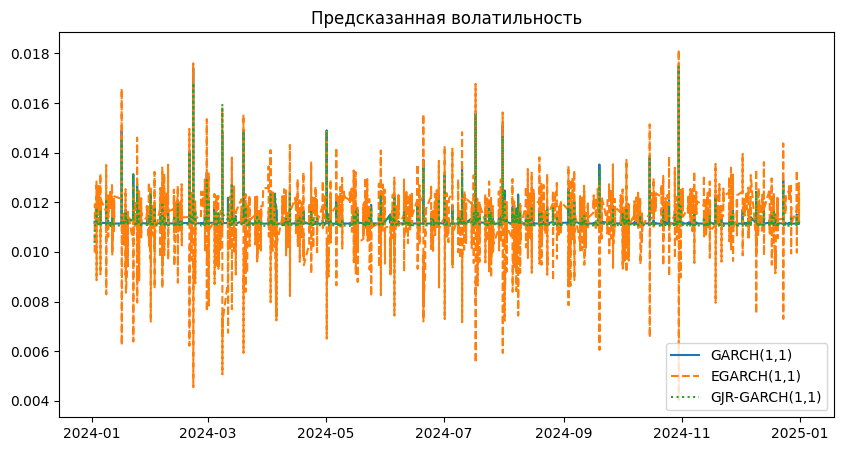

In [266]:
plt.figure(figsize=(10,5))
plt.plot(returns.index, garch_result.conditional_volatility, label="GARCH(1,1)")
plt.plot(returns.index, egarch_result21.conditional_volatility, label="EGARCH(1,1)", linestyle='dashed')
plt.plot(returns.index, gjr_result.conditional_volatility, label="GJR-GARCH(1,1)", linestyle='dotted')
plt.title("Предсказанная волатильность")
plt.legend()
plt.show()


Попробуем предсказать волатильность с помощью лучшей модели

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                4843.63
Distribution:                  Normal   AIC:                          -9677.27
Method:            Maximum Likelihood   BIC:                          -9650.44
                                        No. Observations:                 1581
Date:                Wed, Mar 19 2025   Df Residuals:                     1580
Time:                        16:55:35   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.9771e-05  3.386e-04 -5.840e-02      0.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarn

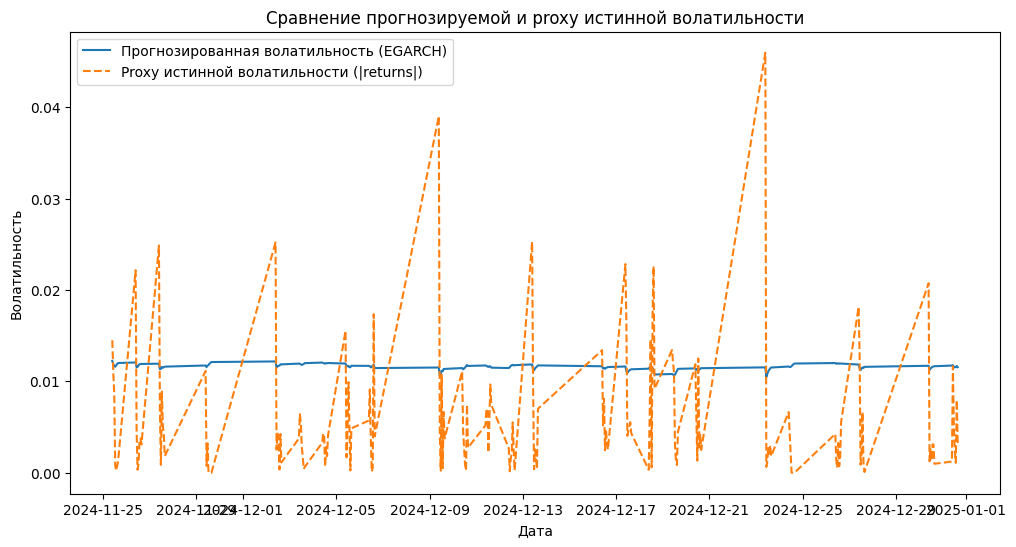

In [267]:
# Вычисляем лог-доходности
data['AMD_log_return'] = np.log(data['AMD'] / data['AMD'].shift(1))
returns = data['AMD_log_return'].dropna()

# Разбивка на обучающую и тестовую выборки
train_size = round(0.9 * len(data['AMD']))
train, test = returns[:train_size], returns[train_size:]

# Обучение EGARCH модели
egarch_model = arch_model(train, vol='EGarch', p=2, q=1)
egarch_result = egarch_model.fit(disp='off')
print(egarch_result.summary())

# Пошаговое прогнозирование
predicted_vol = []
history = train.copy()

for t in test.index:
    model = arch_model(history, vol='EGarch', p=1, q=1)
    result = model.fit(disp='off')
    forecast = result.forecast(horizon=1)

    # Берём корень из дисперсии и ограничиваем возможные выбросы
    vol = np.sqrt(forecast.variance.iloc[-1, 0])
    vol = np.clip(vol, 0, np.percentile(history.abs(), 99))  # Ограничение выбросов
    predicted_vol.append(vol)

    # Добавляем текущее значение в историю
    history.loc[t] = test.loc[t]

# Преобразуем список предсказаний в Series
predicted_vol = pd.Series(predicted_vol, index=test.index)

# В качестве proxy для истинной волатильности используем абсолютные значения доходностей тестовой выборки
realized_vol = test.abs()

# Визуализация: сравнение прогнозируемой и proxy истинной волатильности
plt.figure(figsize=(12, 6))
plt.plot(predicted_vol.index, predicted_vol, label='Прогнозированная волатильность (EGARCH)')
plt.plot(realized_vol.index, realized_vol, label='Proxy истинной волатильности (|returns|)', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.title('Сравнение прогнозируемой и proxy истинной волатильности')
plt.legend()
plt.show()

Наши данные низкочастотные, поэтому волатильность получается низкой

## 6.	Построить VAR модель

In [268]:
from statsmodels.tsa.api import VAR

# Используем дифференцированные данные
model = VAR(data_diff)

# Выбираем оптимальное число лагов (например, максимум 15)
lag_order_results = model.select_order(maxlags=15)
print(lag_order_results.summary())

# Определяем оптимальное число лагов по критерию AIC (или любому другому, например, BIC)
selected_lag = lag_order_results.selected_orders['aic']
print("Оптимальное число лагов (AIC):", selected_lag)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0     -0.6154*    -0.6060*     0.5404*    -0.6119*
1      -0.6099     -0.5723      0.5434     -0.5960
2      -0.6019     -0.5360      0.5478     -0.5775
3      -0.5953     -0.5012      0.5514     -0.5605
4      -0.5892     -0.4669      0.5548     -0.5440
5      -0.5803     -0.4297      0.5597     -0.5246
6      -0.5743     -0.3954      0.5631     -0.5081
7      -0.5808     -0.3737      0.5595     -0.5042
8      -0.5730     -0.3377      0.5638     -0.4860
9      -0.5676     -0.3041      0.5669     -0.4702
10     -0.5583     -0.2666      0.5722     -0.4504
11     -0.5510     -0.2310      0.5764     -0.4327
12     -0.5441     -0.1958      0.5804     -0.4153
13     -0.5367     -0.1602      0.5847     -0.3975
14     -0.5611     -0.1563      0.5706     -0.4114
15     -0.5522     -0.1193      0.5757     -0.3921
-------------------------------

Странно строить модель с числом лагов 0, поробуем с числом лагов равным 3

In [269]:
# Подгоняем модель с выбранным числом лагов
selected_lag=3
model_fitted = model.fit(selected_lag)
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Mar, 2025
Time:                     16:55:51
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.516393
Nobs:                     1753.00    HQIC:                 -0.575393
Log likelihood:          -6897.54    FPE:                   0.543357
AIC:                    -0.609989    Det(Omega_mle):        0.534164
--------------------------------------------------------------------
Results for equation AMD
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.005613         0.044497           -0.126           0.900
L1.AMD          0.004814         0.029364            0.164           0.870
L1.INTC         0.076233         0.118325            0.644           0.519
L1.NVDA    

Построим графики влияния шоков одной величины на другую

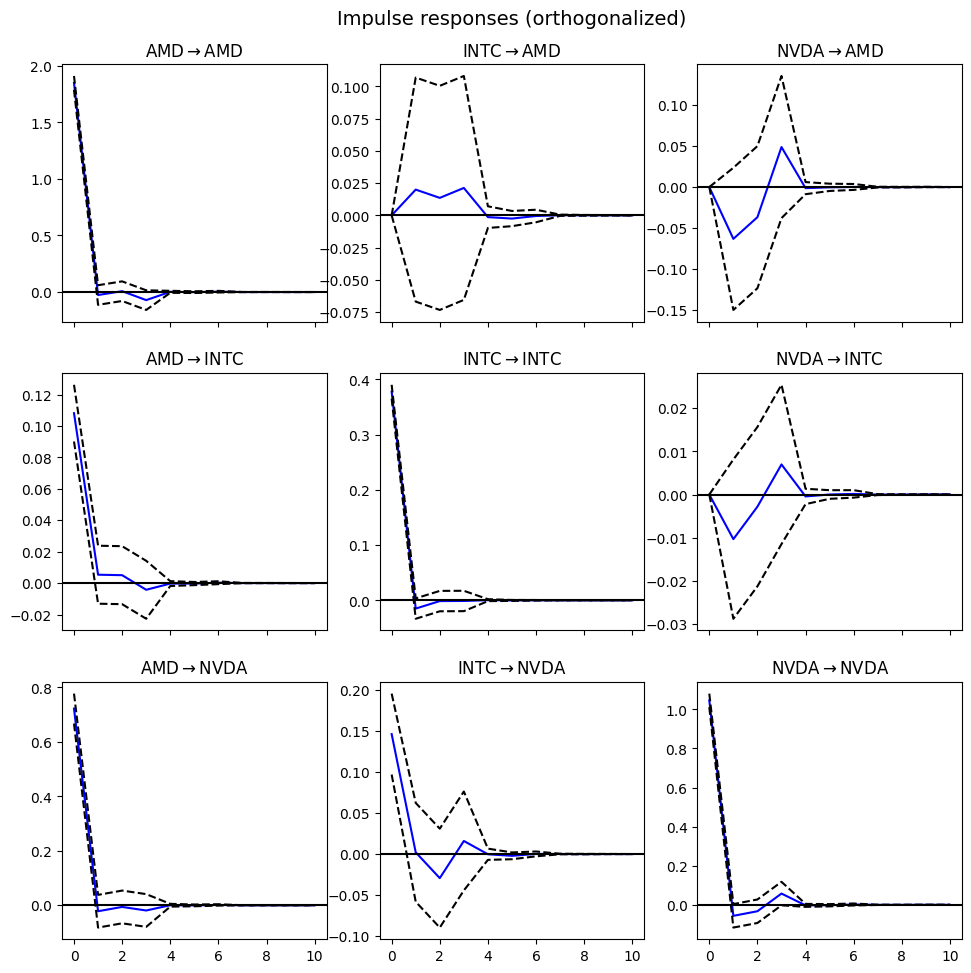

In [270]:
import matplotlib.pyplot as plt

# Рассчёт IRF на 10 периодов вперёд
irf = model_fitted.irf(10)
irf.plot(orth=True)
plt.show()

Структура графика:

Каждая панель (подграфик) показывает влияние одного временного ряда на другой.
По диагонали расположены графики типа "сам на себя" (например, AMD → AMD).
Остальные панели показывают перекрёстные влияния (например, AMD → INTC, INTC → NVDA).
Что означают линии?

Синяя линия — среднее значение отклика (влияние шока).
Чёрные пунктирные линии — доверительный интервал (обычно 95%).
Как интерпретировать отклики?

Если синяя линия уходит в плюс, то шок в первом ряду вызывает рост второго ряда.
Если синяя линия уходит в минус, то шок в первом ряду вызывает падение второго ряда.
Если доверительный интервал (чёрные линии) пересекает 0, влияние шока может быть статистически незначимым.
Влияние обычно затухает через несколько шагов.
Интерпретация результатов:
AMD → AMD (верхний левый график):

В начале резкий скачок вверх, затем влияние затухает. Это логично: если в AMD произошёл резкий рост, он постепенно возвращается к среднему.
INTC → AMD и NVDA → AMD (верхний ряд, средний и правый графики):

Влияние небольшое, и доверительный интервал широкий (шок INTC или NVDA слабо влияет на AMD).
AMD → INTC и INTC → INTC (средний ряд, левый и средний графики):

AMD оказывает небольшое влияние на INTC, но быстро затухающее.
Шок INTC влияет на сам себя, но также быстро возвращается к нулю.
AMD → NVDA (нижний левый график):

Всплеск в первую пару периодов, затем постепенное затухание.
Значит, изменения в AMD могут временно повлиять на NVDA.
NVDA → NVDA (нижний правый график):

Сильный скачок вверх и постепенный спад.
Это ожидаемо: шок в NVDA сначала сильно влияет на сам себя.
Основные выводы:
AMD, INTC и NVDA взаимосвязаны, но с разной силой.
AMD → NVDA имеет более сильное влияние, чем AMD → INTC.
NVDA наиболее волатильна (резкие движения вверх и вниз).
INTC оказывает слабое влияние на другие акции.
Если цель – предсказать поведение одного из активов, стоит учитывать, что AMD и NVDA реагируют сильнее, чем INTC.

In [271]:
# Получаем последние значения для формирования прогнозного интервала
lag_order = selected_lag
forecast_input = data_diff.values[-lag_order:]
forecast = model_fitted.forecast(y=forecast_input, steps=10)
print(forecast)

[[ 0.02554356 -0.00870679  0.05484156]
 [ 0.0365881  -0.01069666  0.12524613]
 [-0.04844717 -0.0229664  -0.00745581]
 [-0.01123899 -0.01578398  0.04867149]
 [-0.00843321 -0.01574097  0.05353795]
 [-0.01121915 -0.01622323  0.04706602]
 [-0.01045112 -0.01601459  0.04908973]
 [-0.01032568 -0.01600582  0.04936829]
 [-0.010536   -0.0160386   0.04902832]
 [-0.01047464 -0.0160278   0.04911971]]


## 7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

In [272]:
!pip install catboost -q

Для ипользования ряда в качестве табличного ML добавим некоторые новые признаки

In [273]:
df = data.copy()
# Добавляем лаги для AMD
for lag in range(1, 6):  # 5 лагов
    df[f'AMD_lag_{lag}'] = df['AMD'].shift(lag)

# Скользящее среднее и стандартное отклонение
df['AMD_rolling_mean'] = df['AMD'].rolling(window=5).mean()
df['AMD_rolling_std'] = df['AMD'].rolling(window=5).std()

# Добавляем INTC и NVDA в качестве регрессоров
df['INTC_lag_1'] = df['INTC'].shift(1)
df['NVDA_lag_1'] = df['NVDA'].shift(1)

# Удаляем пропущенные значения
df.dropna(inplace=True)

# Разделение на train/test
train_size = round(0.9 * len(data['AMD']))
train, test = df.iloc[:train_size], df.iloc[train_size:]
X_train, y_train = train.drop(columns=['AMD']), train['AMD']
X_test, y_test = test.drop(columns=['AMD']), test['AMD']

Посмотрим на итоговый датасет

In [274]:
print(df.head())

Ticker                            AMD       INTC       NVDA  AMD_log_return  \
Datetime                                                                      
2024-01-02 14:30:00-05:00  137.824997  47.494999  47.883999       -0.004596   
2024-01-02 15:30:00-05:00  138.600098  47.820000  48.185001        0.005608   
2024-01-03 09:30:00-05:00  134.699905  47.215000  47.494488       -0.028543   
2024-01-03 10:30:00-05:00  134.889297  47.070000  47.751503        0.001405   
2024-01-03 11:30:00-05:00  135.380005  47.040001  47.773991        0.003631   

Ticker                      AMD_lag_1   AMD_lag_2   AMD_lag_3   AMD_lag_4  \
Datetime                                                                    
2024-01-02 14:30:00-05:00  138.459900  139.175003  139.259995  139.856598   
2024-01-02 15:30:00-05:00  137.824997  138.459900  139.175003  139.259995   
2024-01-03 09:30:00-05:00  138.600098  137.824997  138.459900  139.175003   
2024-01-03 10:30:00-05:00  134.699905  138.600098  137.824997

Обучим XGBoost

In [275]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Обучаем XGBoost
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# Предсказания
y_pred_xgb = xgb_model.predict(X_test)

# Оценка качества
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb}")


XGBoost MAE: 4.439280192057292


Обучим CatBoost

In [276]:
from catboost import CatBoostRegressor

# Обучаем CatBoost
cat_model = CatBoostRegressor(iterations=200, learning_rate=0.05, depth=6, verbose=0)
cat_model.fit(X_train, y_train)

# Предсказания
y_pred_cat = cat_model.predict(X_test)

# Оценка качества
mae_cat = mean_absolute_error(y_test, y_pred_cat)
print(f"CatBoost MAE: {mae_cat}")


CatBoost MAE: 5.036415565923607


Видно, что в данном случае XGBoost оказался лучше по МАЕ

In [277]:
print(f"XGBoost MAE: {mae_xgb}")
print(f"CatBoost MAE: {mae_cat}")


XGBoost MAE: 4.439280192057292
CatBoost MAE: 5.036415565923607


Сравним предсказания с реальными значениями

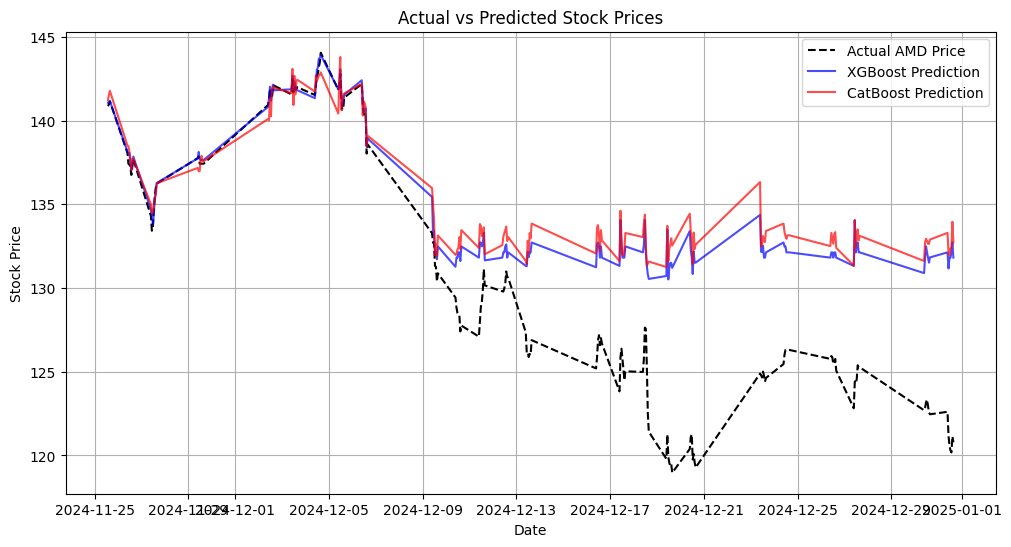

In [278]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label="Actual AMD Price", color='black', linestyle='dashed')
plt.plot(test.index, y_pred_xgb, label="XGBoost Prediction", color='blue', alpha=0.7)
plt.plot(test.index, y_pred_cat, label="CatBoost Prediction", color='red', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid()
plt.show()


Модели хороши на короткий срок, но чем дальше, тем хуже



Посмотрим на график остатков

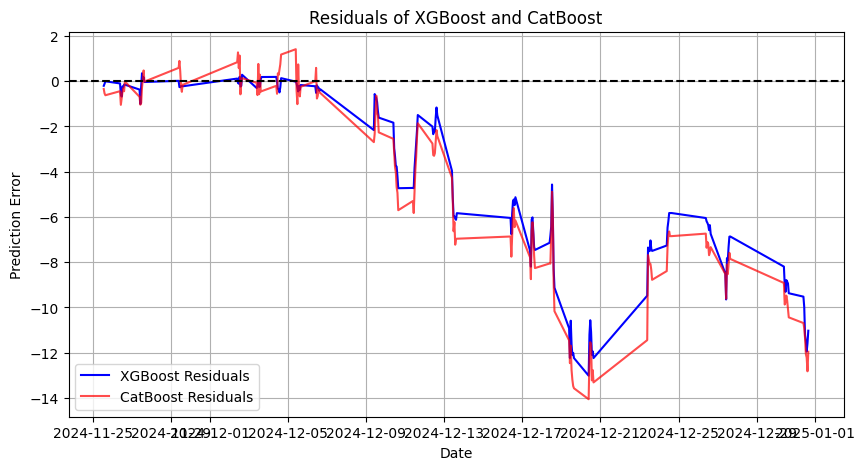

In [279]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_test - y_pred_xgb, label="XGBoost Residuals", color='blue')
plt.plot(test.index, y_test - y_pred_cat, label="CatBoost Residuals", color='red', alpha=0.7)
plt.axhline(0, color='black', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.title("Residuals of XGBoost and CatBoost")
plt.legend()
plt.grid()
plt.show()


## 8.	Построить модель на нейронных сетях

Используем модель LSTM

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

df = data.copy()
# Выбираем основной ряд (AMD)
data = df["AMD"].values.reshape(-1, 1)

#Нормализуем
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

train_size = round(0.9 * len(df['AMD']))

In [339]:
# Функция для создания окон данных
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Создаём последовательности
seq_length = 30  # Можно варьировать
X, y = create_sequences(data_scaled, seq_length)

# Разделяем на train/test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Преобразуем в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Создаём DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [340]:
# Определяем LSTM-модель
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Инициализируем модель
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Проверим форму X_train

In [341]:
print("Форма X_train:", X_train_tensor.shape)  # Ожидается (batch_size, seq_length, число_признаков)


Форма X_train: torch.Size([1581, 30, 1])


Обучим модель

In [342]:
# Обучение модели
epochs = 50
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.0114
Epoch 5, Loss: 0.0003
Epoch 10, Loss: 0.0007
Epoch 15, Loss: 0.0010
Epoch 20, Loss: 0.0012
Epoch 25, Loss: 0.0004
Epoch 30, Loss: 0.0003
Epoch 35, Loss: 0.0005
Epoch 40, Loss: 0.0004
Epoch 45, Loss: 0.0008


Сравним предсказания и реальные данные

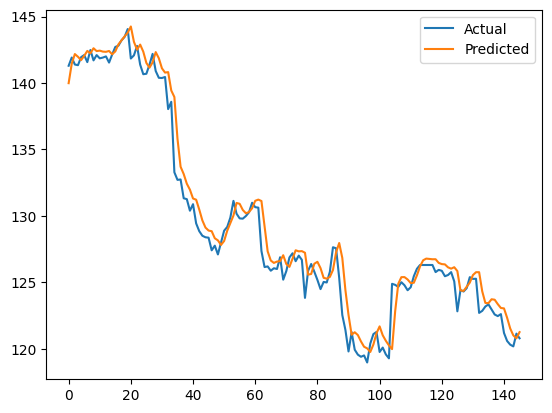

In [343]:
# Тестирование модели
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Обратное преобразование и оценка
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Визуализация результатов
import matplotlib.pyplot as plt
plt.plot(y_test_actual, label="Actual")
plt.plot(y_pred_actual, label="Predicted")
plt.legend()
plt.show()

Есть подозрения что модель просто копирует график с небольшим интервалом, поэтому график и метрика такие хорошие

Оценим MAE

In [344]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.9763


Ошибка оказалсь маленькой из-за переобучения